# 📹 Processing Video with GPT-4o’s Vision Capabilities  

This notebook demonstrates how to leverage **GPT-4o’s vision model** to extract structured insights from video footage by analyzing selected keyframes.


## 🚩 Business Problem: Lack of Real-Time Visibility

Managers lack a real-time view of what’s happening on the floor. They rely on manual reports or delayed data entry which makes it hard to spot issues until they become bigger headaches. Without live real-time tracking, decisions are reactive instead of proactive

See image below for a warehouse layout.  This warehouse is packed with activity and lacks real-time tracking, making operations messy and inefficient

![Warehouse Layout](warehouse_pic.png)

## ✅ Proposed Solution: AI-Powered Monitoring

Using **computer vision** to analyze warehouse videos and provide real-time operational insights

### 📌 Simple Workflow:

1. **Grab Frames:** Pull key images from warehouse videos and mark your inspection area clearly.

2. **Prepare for GPT-4o:** Format these images to easily feed into GPT-4o.

3. **Analyze & Get Insights:** GPT-4o identifies workers, checks safety, and rates space utilization.

4. **Review Results:** Quickly verify and analyze insights using simple data tables.

5. **Optimize & Save Costs:** Fine-tune image quality and frequency to keep things efficient and affordable.

### Step 1: Set Up Environment

In [81]:
from IPython.display import display, Image, Audio

import cv2  # We're using OpenCV to read video, to install !pip install opencv-python
import base64
import time
from openai import OpenAI
import os
import requests
from dotenv import load_dotenv
load_dotenv(override=True)

# Verify that OPENAI_API_KEY is loaded correctly
api_key = os.getenv("OPENAI_API_KEY")
if api_key:
    print("OPENAI_API_KEY loaded successfully.")
else:
    print("Failed to load OPENAI_API_KEY.")

client = OpenAI(api_key=api_key)

OPENAI_API_KEY loaded successfully.


### Step 2: Extract and Process Frames

**Best Practice:**  
Use a bounding box to help the LLM focus on a specific area of the image or video feed.


1018 frames with bounding box read.
Selected 3 evenly spaced frames with bounding box.


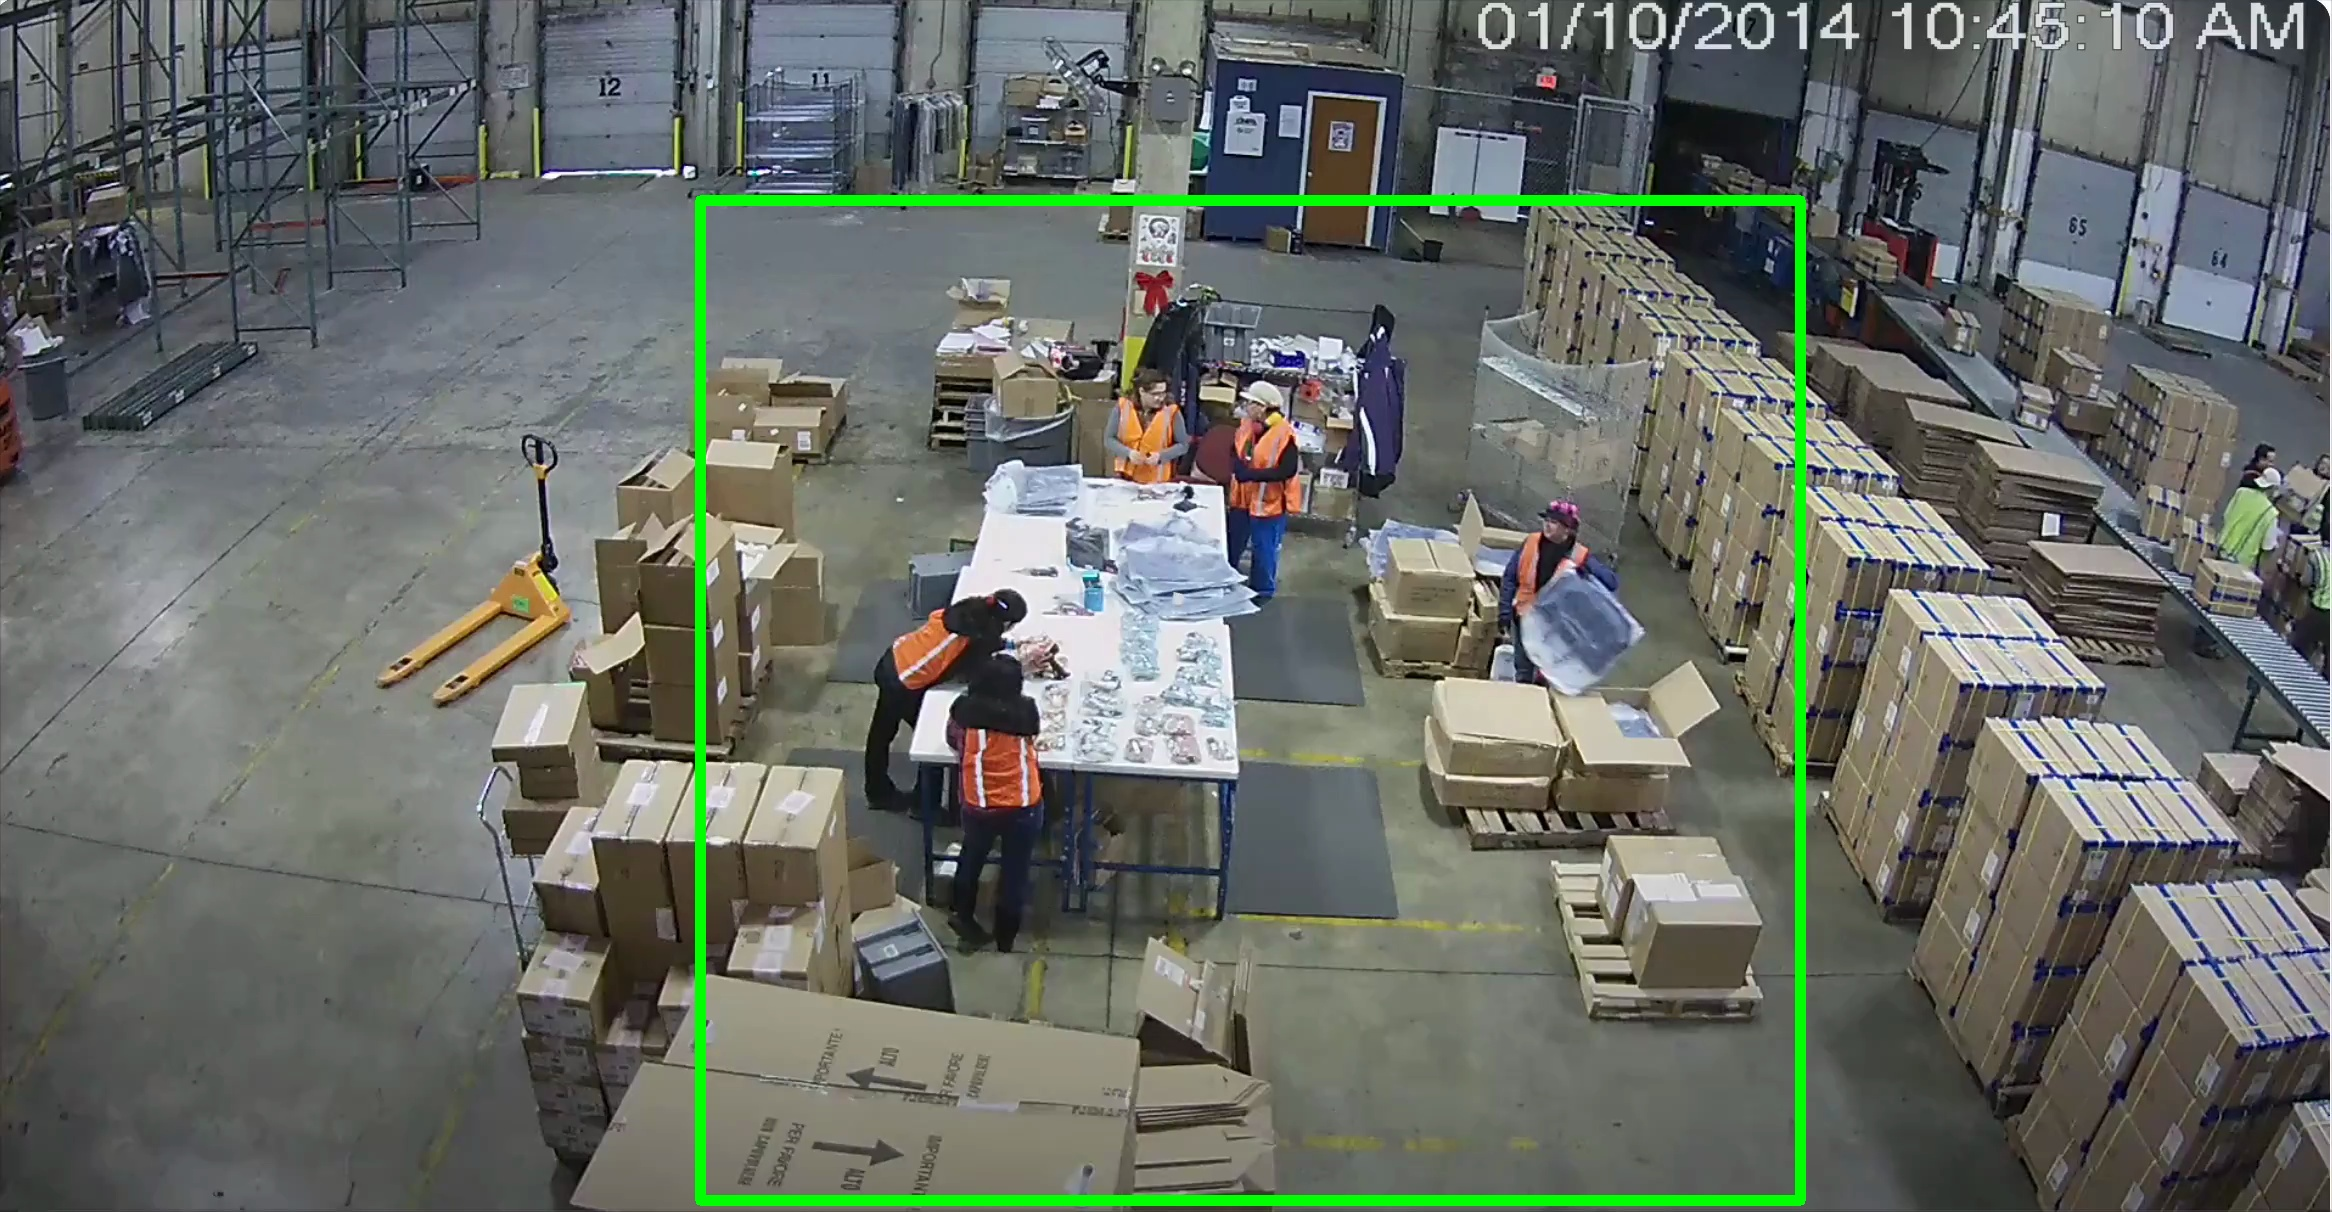

In [105]:
# Define bounding box coordinates (adjust these values as needed)
bbox_top_left = (700, 200)  # (x, y) coordinates of the top-left corner
bbox_bottom_right = (1800, 1200)  # (x, y) coordinates of the bottom-right corner
bbox_color = (0, 255, 0)  # Green color for bounding box
bbox_thickness = 10  # Thickness of bounding box lines

# Extract frames from the cropped video, add bounding box, and encode them as base64 strings
video = cv2.VideoCapture("/Users/anurag/github/openai-cookbook/openai-cookbook/examples/data/manufacturing/warehouse_operations.mp4")
base64FramesWithBBox = []
while video.isOpened():
    success, frame = video.read()
    if not success:
        break
    # Draw bounding box on the frame
    frame_with_bbox = cv2.rectangle(frame.copy(), bbox_top_left, bbox_bottom_right, bbox_color, bbox_thickness)
    _, buffer = cv2.imencode(".jpg", frame_with_bbox)
    base64FramesWithBBox.append(base64.b64encode(buffer).decode("utf-8"))

video.release()
print(len(base64FramesWithBBox), "frames with bounding box read.")

# Select 3 evenly spaced frames from base64FramesWithBBox
num_frames_bbox = len(base64FramesWithBBox)
selected_indices_bbox = [int(i * num_frames_bbox / 3) for i in range(3)]
selectedBase64FramesWithBBox = [base64FramesWithBBox[i] for i in selected_indices_bbox]
print(f"Selected {len(selectedBase64FramesWithBBox)} evenly spaced frames with bounding box.")

from IPython.display import display, Image
import base64

display(Image(data=base64.b64decode(selectedBase64FramesWithBBox[0])))

### Step 3: Define Structured Data Schema

**Best Practice:**  
Include confidence levels in your predictions.



In [106]:
from pydantic import BaseModel

class MfgEvent(BaseModel):
    timestamp: str
    timestamp_confidence: float  # Confidence level (0.0 to 1.0)
    spaceUtilization: str  # e.g., 'low', 'moderate', 'high'
    spaceUtilization_confidence: float  # Confidence level (0.0 to 1.0)
    workers_in_inspection_area: int
    workers_in_inspection_area_confidence: float  # Confidence level (0.0 to 1.0)
    workers_in_inspection_area_explanation: str
    workers_wearing_safety: bool
    workers_wearing_safety_confidence: float  # Confidence level (0.0 to 1.0)
    unused_forklift: bool
    unused_forklift_confidence: float  # Confidence level (0.0 to 1.0)
    conveyor_belt_items: bool
    conveyor_belt_items_confidence: float  # Confidence level (0.0 to 1.0)

### Step 4: Extract Data with GPT-4o

**Best Practice:**  
Process frames sequentially to track potential movement trends

/var/folders/9k/2_ftf__j2v1f1llz6lzk40700000gp/T/ipykernel_73823/4214534331.py:74: PydanticDeprecatedSince20: The `dict` method is deprecated; use `model_dump` instead. Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Guide at https://errors.pydantic.dev/2.10/migration/
  events_list.append(event.dict())


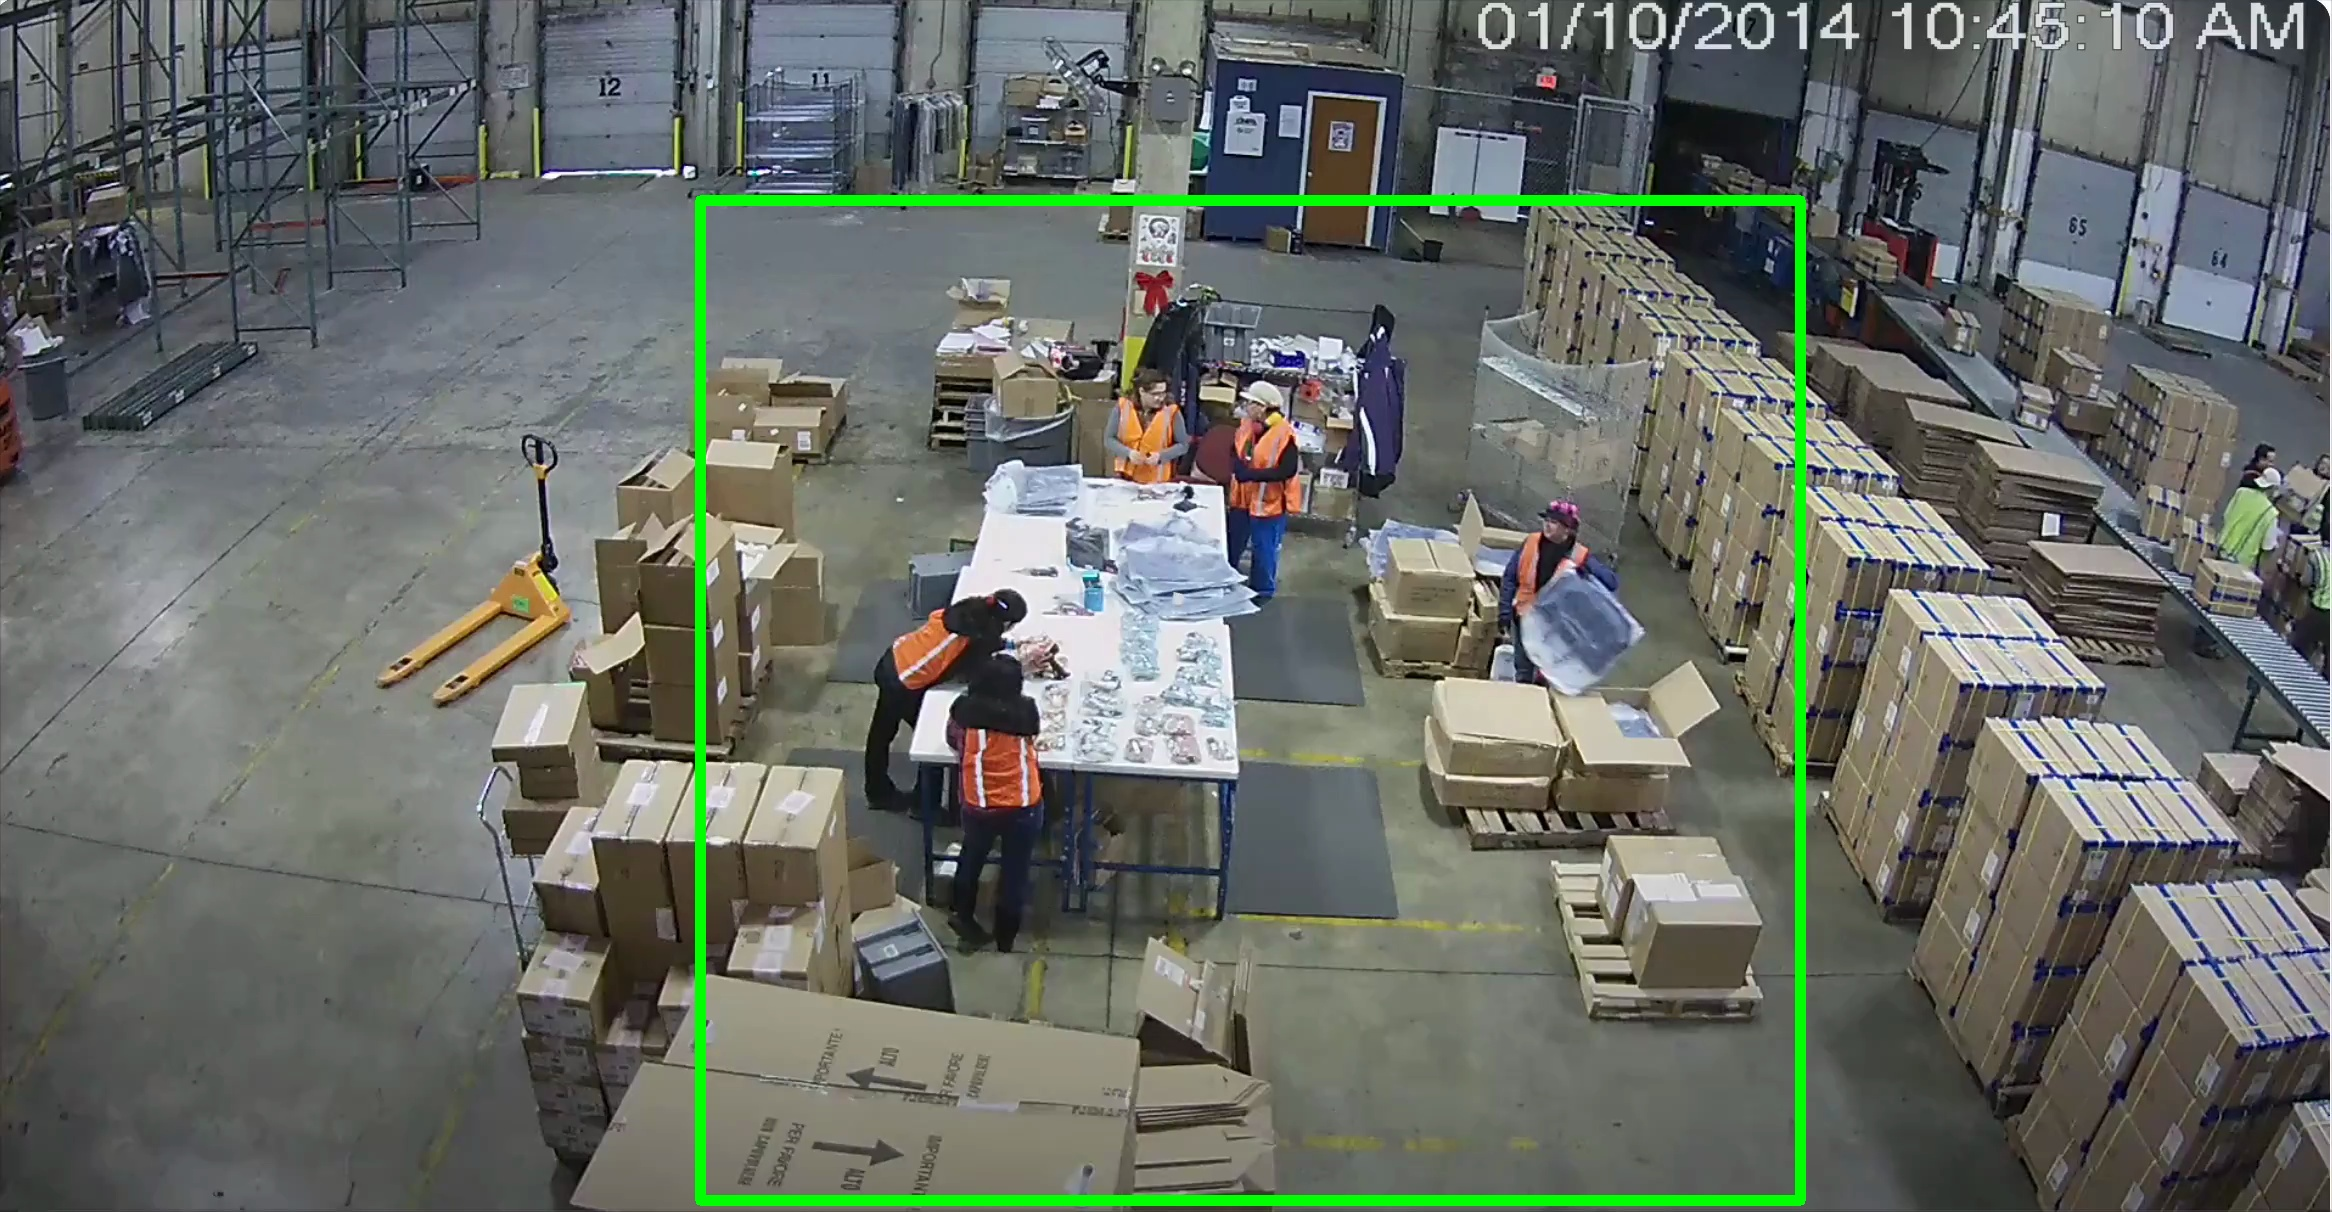

timestamp='01/10/2014 10:45:10 AM' timestamp_confidence=1.0 spaceUtilization='high' spaceUtilization_confidence=0.95 workers_in_inspection_area=6 workers_in_inspection_area_confidence=0.95 workers_in_inspection_area_explanation='1. Worker at the bottom center, bending over the table. 2. Two workers standing on the right side of the table. 3. Two workers at the top center of the table. 4. One worker at the bottom right corner handling a box.' workers_wearing_safety=True workers_wearing_safety_confidence=0.95 unused_forklift=True unused_forklift_confidence=0.9 conveyor_belt_items=True conveyor_belt_items_confidence=0.9


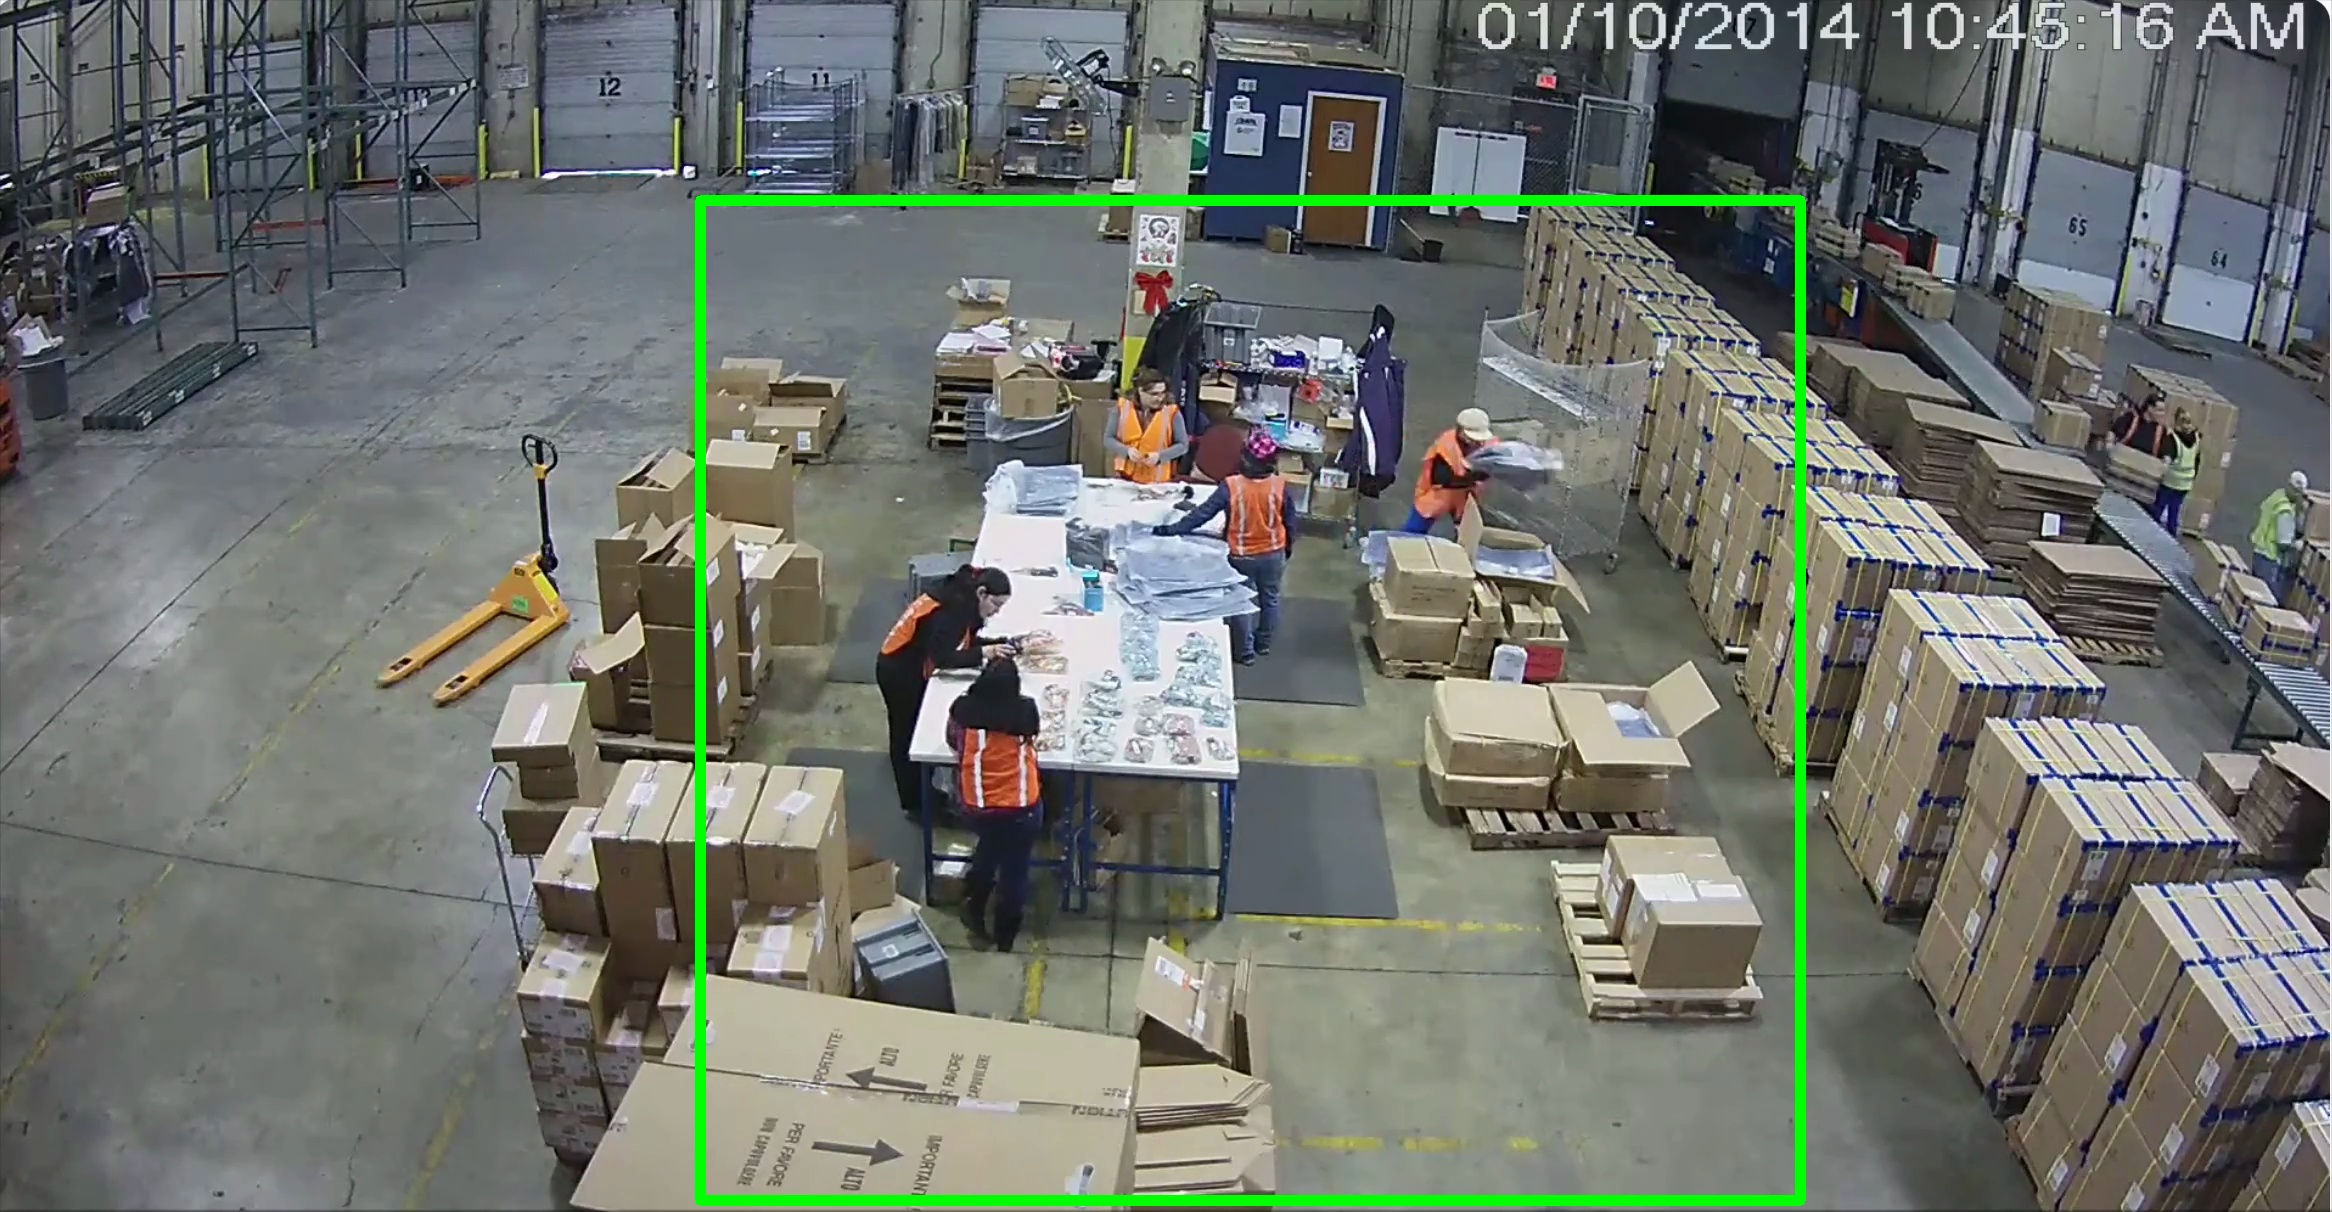

timestamp='01/10/2014 10:45:16 AM' timestamp_confidence=0.9 spaceUtilization='high' spaceUtilization_confidence=0.9 workers_in_inspection_area=3 workers_in_inspection_area_confidence=0.9 workers_in_inspection_area_explanation='Three workers are visible inside the green bounding box, all wearing orange safety vests. One worker is on the left side of the table, bending over papers. Another worker is standing at the right end of the table, handling objects. The third worker is in front of the table, facing towards it.' workers_wearing_safety=True workers_wearing_safety_confidence=1.0 unused_forklift=False unused_forklift_confidence=0.8 conveyor_belt_items=True conveyor_belt_items_confidence=0.9


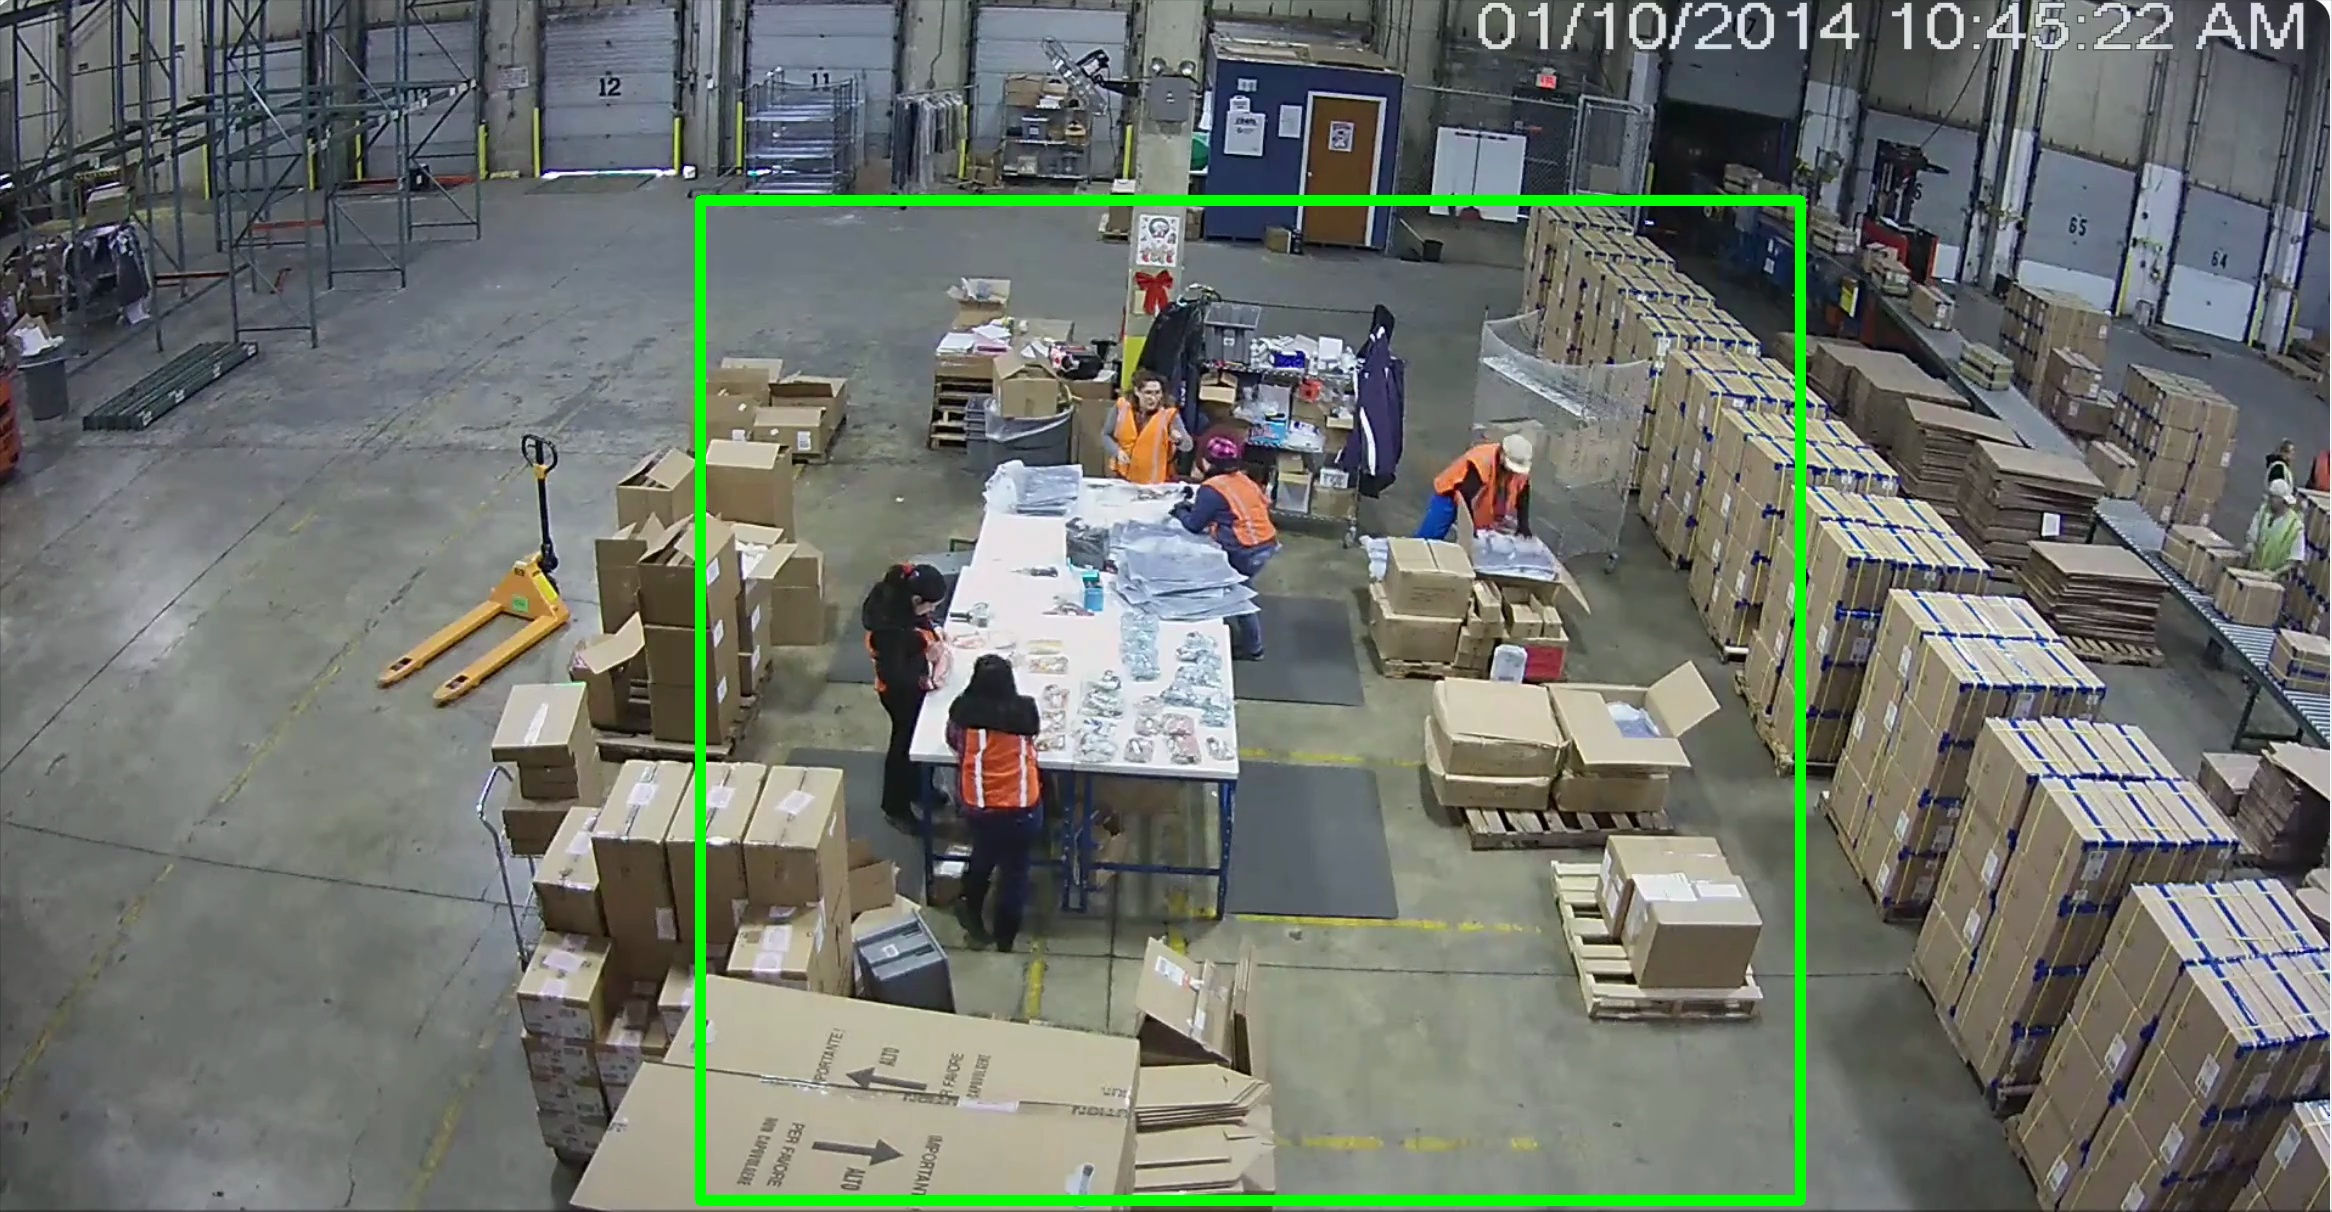

timestamp='01/10/2014 10:45:22 AM' timestamp_confidence=1.0 spaceUtilization='high' spaceUtilization_confidence=0.9 workers_in_inspection_area=5 workers_in_inspection_area_confidence=1.0 workers_in_inspection_area_explanation='Five workers are visible inside the green bounding box, each wearing an orange safety vest. Two are on the left side of the table, and three are on the right side, all clearly visible without occlusion.' workers_wearing_safety=True workers_wearing_safety_confidence=1.0 unused_forklift=True unused_forklift_confidence=0.9 conveyor_belt_items=True conveyor_belt_items_confidence=0.8


In [110]:
events_list = []

# Loop through selected frames and analyze them
for frame in selectedBase64FramesWithBBox:
    completion = client.beta.chat.completions.parse(
        model="gpt-4o",
        messages=[
            {
                "role": "system",
                "content": (
                    "You are an AI model analyzing video frames from a logistics warehouse to extract structured insights related to safety, space utilization, "
                    "and operational efficiency. Your task is to analyze each frame based on the `MfgEvent` model and ensure precise worker detection, "
                    "bounding box interpretation, and confidence scoring.\n\n"

                    "**Your output must strictly adhere to the following schema:**\n\n"

                    "**`MfgEvent` Schema:**\n"
                    "- `timestamp` (str): The timestamp associated with this frame.\n"
                    "- `timestamp_confidence` (float): Confidence level (0.0 - 1.0) for timestamp accuracy.\n"
                    "- `spaceUtilization` (str): Describe space utilization as 'low', 'moderate', or 'high'.\n"
                    "- `spaceUtilization_confidence` (float): Confidence level (0.0 - 1.0) for space utilization classification.\n"
                    "- `workers_in_inspection_area` (int): Count of workers **strictly inside the green bounding box**, identified by their **orange safety vests**.\n"
                    "- `workers_in_inspection_area_confidence` (float): Confidence level (0.0 - 1.0) for worker count accuracy.\n"
                    "- `workers_in_inspection_area_explanation` (str): Provide **explicit proof** of each detected worker. "
                    "List every worker and their approximate **position relative to the green bounding box**. "
                    "If visibility issues exist (e.g., occlusions, motion blur, shadows), explain how you accounted for them.\n"
                    "- `workers_wearing_safety` (bool): `True` if **all visible workers** are wearing safety vests, `False` otherwise.\n"
                    "- `workers_wearing_safety_confidence` (float): Confidence level (0.0 - 1.0) for safety gear detection.\n"
                    "- `unused_forklift` (bool): `True` if a forklift is present but **not in use**, `False` otherwise.\n"
                    "- `unused_forklift_confidence` (float): Confidence level (0.0 - 1.0) for forklift status determination.\n"
                    "- `conveyor_belt_items` (bool): `True` if **boxes are present on the conveyor belt, including the right side of the screen**, `False` otherwise.\n"
                    "- `conveyor_belt_items_confidence` (float): Confidence level (0.0 - 1.0) for conveyor belt item detection.\n\n"

                    "**Guidelines for Image Analysis:**\n"
                    "- **Worker Counting in Inspection Area**:\n"
                    "  - Focus **only** on workers **inside the green bounding box**.\n"
                    "  - **Double-check** the count by confirming workers wearing **orange safety vests**.\n"
                    "  - If workers are **partially visible**, explain your estimation method (e.g., partial torso visible, shadow confirmation, pattern recognition).\n"
                    "  - If confidence is low due to occlusions or lighting, explicitly state the reason and how you accounted for uncertainty.\n\n"

                    "- **Safety Compliance Detection**:\n"
                    "  - Assess whether **every visible worker** is wearing proper safety gear.\n"
                    "  - If a worker's vest is obscured, indicate how you made a decision (e.g., assumption based on surrounding workers, reflection, or historical patterns).\n\n"

                    "- **Forklift Status Determination**:\n"
                    "  - Clearly differentiate between **active** and **idle** forklifts based on positioning, movement indicators, or operator presence.\n"
                    "  - If a forklift is **partially visible**, explain how you assessed its status.\n\n"

                    "- **Conveyor Belt Item Detection**:\n"
                    "  - Pay **special attention to the right side** of the screen to confirm the presence of boxes.\n"
                    "  - If boxes are partially visible or obstructed, explain how you determined their presence.\n\n"

                    "- **Confidence Scoring & Transparency**:\n"
                    "  - Avoid assumptions—if confidence is **below 0.5**, explain why and whether manual review is needed.\n"
                    "  - High confidence (0.9 - 1.0) should be used **only when detection is extremely clear**."
                )
            },
            {
                "role": "user",
                "content": [
                    "I am providing a frame from a video taken inside a logistics warehouse. Your job is to analyze this image and extract structured data "
                    "based on the `MfgEvent` schema. **Focus only on the inspection area within the green bounding box** when counting workers. "
                    "Also, ensure you check the **right side of the conveyor belt for any boxes**. Your response must follow the structured schema format."
                ] + [{"image": frame, "resize": 768}],
            },
        ],
        response_format=MfgEvent
    )

    # Extract the structured response
    event = completion.choices[0].message.parsed

    # Store the structured data in the event list
    events_list.append(event.dict())

    # Display the frame for verification
    from IPython.display import Image
    display(Image(data=base64.b64decode(frame.encode("utf-8"))))
    print(event)

### Step 4: Extract Structured Data Using GPT-4o

The `events_list` is a collection of dictionaries, each representing structured insights extracted from individual video frames. Converting this list into a **pandas DataFrame** makes the data easier to interpret, filter, and analyze.

With a DataFrame, you can:

- ✅ Quickly identify trends in **worker behavior**.
- ✅ Monitor changes in **space utilization** over time.
- ✅ Track **safety compliance** more effectively.

---

⚠️ **Limitations:**

While GPT-4o’s vision model provides powerful capabilities, it’s important to note some limitations:

- The model provides **approximate counts** of workers due to potential occlusions or partial visibility.
- Accuracy depends heavily on the **quality of the images** (lighting conditions, clarity, motion blur, etc.).
- Lower confidence scores indicate cases where manual review might be necessary.


In [100]:
import pandas as pd

# Convert events_list to a pandas DataFrame and display it
df_events = pd.DataFrame(events_list)
display(df_events)

timestamp  timestamp_confidence spaceUtilization  \
0  01/10/2014 10:45:10 AM                  0.99             high   
1  01/10/2014 10:45:16 AM                  1.00             high   
2  01/10/2014 10:45:22 AM                  1.00             high   

   spaceUtilization_confidence  workers_in_inspection_area  \
0                         0.95                           5   
1                         0.90                           5   
2                         0.80                           4   

   workers_in_inspection_area_confidence  \
0                                   0.95   
1                                   1.00   
2                                   0.90   

              workers_in_inspection_area_explanation  workers_wearing_safety  \
0  Five workers wearing orange safety vests are c...                    True   
1  Five workers are clearly visible inside the gr...                    True   
2  Detected four workers inside the green boundin...                    True   

   workers_wearing_safety_confidence  unused_forklift  \
0                               0.95             True   
1                               1.00             True   
2                               0.90             True   

   unused_forklift_confidence  conveyor_belt_items  \
0                         0.9                 True   
1                         0.9                 True   
2                         0.8                 True   

   conveyor_belt_items_confidence  
0                             0.9  
1                             0.9  
2                             0.7

### Step 5: 💸 Cost Considerations & Best Practices

| Factor          | Effect                             |
|-----------------|------------------------------------|
| **Resolution**  | Higher resolution, higher costs    |
| **Detail Mode** | High: 170 tokens/tile + 85 tokens; Low: 85 tokens total |

**Reducing Costs:**

- Reduce resolution
- Trigger frames based on motion
- Opt for lower-detail mode when applicable


In [112]:
from PIL import Image
import math
import base64
from io import BytesIO

# GPT model configuration
GPT_MODEL = "gpt-4o"
GPT_MODEL_VERSION = "gpt-4o-2024-08-06"
INPUT_COST_PER_MILLION_TOKENS = 2.50


def calculate_token_cost(image_data, detail_mode='high'):
    image = Image.open(BytesIO(base64.b64decode(image_data)))
    original_width, original_height = image.size
    
    shortest_side = min(original_width, original_height)
    scale_factor = 768 / shortest_side
    
    scaled_width = int(original_width * scale_factor)
    scaled_height = int(original_height * scale_factor)
    
    tiles_x = math.ceil(scaled_width / 512)
    tiles_y = math.ceil(scaled_height / 512)
    total_tiles = tiles_x * tiles_y
    
    if detail_mode == 'high':
        token_cost = 170 * total_tiles + 85
    elif detail_mode == 'low':
        token_cost = 85
    else:
        raise ValueError("Invalid detail mode. Choose 'high' or 'low'.")
    
    return token_cost

# Calculate cost for one image
single_image_cost = calculate_token_cost(selectedBase64FramesWithBBox[0])

# Extrapolate cost over one year (1 image per minute)
images_per_year = 60 * 24 * 365
annual_token_count = single_image_cost * images_per_year

# Calculate total annual cost based on token usage
total_annual_cost = (annual_token_count / 1_000_000) * INPUT_COST_PER_MILLION_TOKENS
print(f"Total annual cost: ${total_annual_cost:.2f}")

Total annual cost: $1451.97
Token cost per image: 1105
Annual token cost (1 image per minute): 1451.97


## 🚀 Conclusion  

This cookbook demonstrates how to leverage **GPT-4o's vision capabilities** to extract structured insights from **video feeds in a manufacturing environment**. By processing keyframes, applying bounding boxes, and analyzing structured outputs, we can **enhance operational efficiency, improve safety compliance, and optimize space utilization**.  

---

### 🔑 Key Takeaways  

- **AI-powered monitoring** provides real-time insights into warehouse operations, reducing reliance on **manual tracking**.
- **Bounding boxes** help focus analysis on **specific areas**, ensuring more accurate results.
- **Confidence scores** improve decision-making by indicating **the reliability of AI-generated insights**.
- **Converting AI-generated data into a DataFrame** allows for **easy trend analysis and reporting**.
- **Optimizing cost factors**—such as **image resolution, processing frequency, and token efficiency**—ensures sustainable AI deployment.

---

### ⚠️ Limitations & Considerations  

- **AI models provide approximate counts** rather than absolute numbers, especially when occlusions or low visibility are present.
- **Model accuracy depends on image quality**—poor lighting or motion blur can affect detection confidence.
- **Cost considerations** are crucial for scaling AI-powered monitoring—reducing frame processing frequency can help control API expenses.

---

### 🌟 Future Enhancements  

To further enhance the monitoring system, we're exploring:

- **Implementing advanced function calling** to streamline interactions between YOLO detections and GPT-4o analysis.
- **Exploring real-time Vision APIs**, currently under development, to achieve true real-time insights and faster decision-making.






